In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns

Tuning GMM Hyperparameters...
Components   Covariance   BIC Score   
----------------------------------------
----------------------------------------


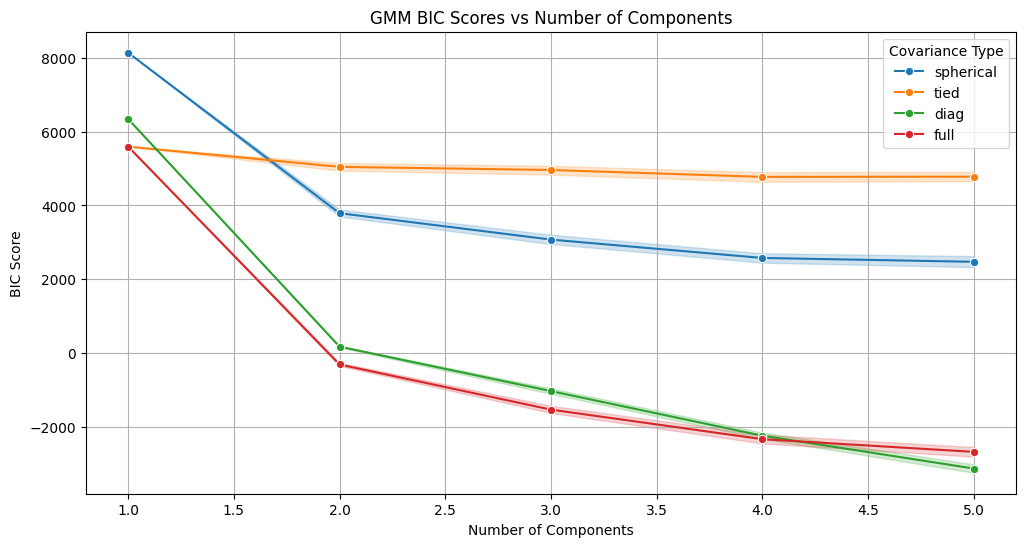


--- PHYSICAL INTERPRETATION OF WINNING MODEL ---
   Cluster ID Weight %  Avg SNR Avg Duration Avg Rise        Physics Label
0           0    11.9%  16.8 dB       0.43 s   0.20 s   Meteor (Overdense)
1           1    11.0%  13.6 dB       0.21 s   0.00 s                Noise
2           2    28.3%  14.6 dB       0.28 s   0.10 s  Meteor (Underdense)
3           3     5.1%  20.5 dB       1.73 s   0.98 s   Meteor (Overdense)
4           4    43.7%  13.0 dB       0.10 s   0.00 s                Noise


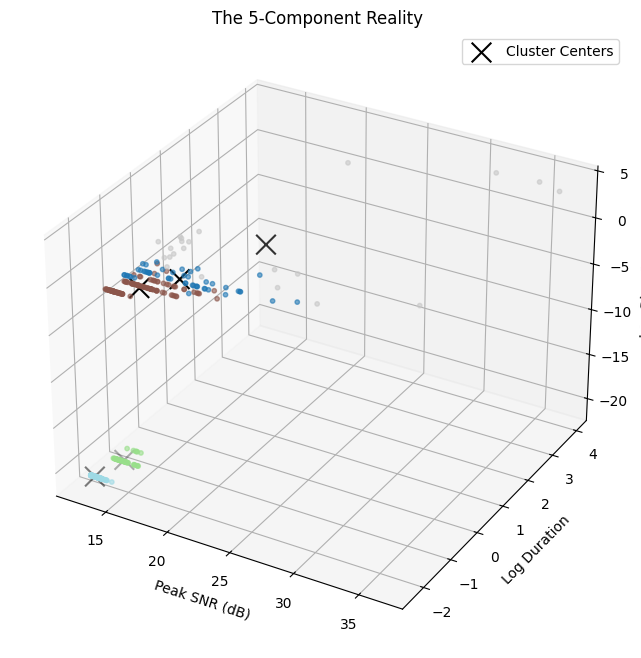

Clusters Identified:
Noise Index: 4
Meteor Index: 1 (Fast Rise)
Anom Index: 2 (Slow Rise)
// PASTE INTO 'model_parameters.h'
float meteor_mu[] = { 13.600486, -1.557676, -20.723266 };
float meteor_prec[] = { 3.493871, -0.300686, -0.000000, -0.300686, 54.643068, 0.000000, -0.000000, 0.000000, 1000000.000000 };
float meteor_log_det = -19.0669; float meteor_log_prior = -2.2090;
float plane_mu[] = { 13.013822, -2.302585, -20.723266 };
float plane_prec[] = { 10.347812, 0.000000, -0.000000, 0.000000, 1000000.000000, 0.000000, -0.000000, 0.000000, 1000000.000000 };
float plane_log_det = -29.9678; float plane_log_prior = -0.8280;
float noise_mu[] = { 15.293371, -1.088547, -2.302585 };
float noise_prec[] = { 0.479653, -1.075616, 0.000000, -1.075616, 33.014585, 0.000000, 0.000000, 0.000000, 1000000.000000 };
float noise_log_det = -16.5019; float noise_log_prior = -1.7154;


In [ ]:
# --- CONFIGURATION ---
INPUT_FILE = "data/brams_geminids_2024.csv"

df = pd.read_csv(INPUT_FILE)
floor = df['snr'].median()
is_active = df['snr'] > (floor + 3.0)
groups = (is_active != is_active.shift()).cumsum()

candidates = []
for gid, group in df[is_active].groupby(groups):
    peak_snr = group['snr'].max()
    duration = len(group) * 0.1 
    
    # NEW FEATURE: Rise Time (Time from start to Peak)
    t_start = group['time'].iloc[0]
    t_peak = group.loc[group['snr'].idxmax(), 'time']
    rise_time = t_peak - t_start
    
    # We log-transform time features to make them Gaussian-friendly
    candidates.append([
        peak_snr, 
        np.log(duration + 1e-9), 
        np.log(rise_time + 1e-9)
    ])

X = np.array(candidates)

n_components_range = range(1, 6) # max 5 components
covariance_types = ['spherical', 'tied', 'diag', 'full']
init_params = ['kmeans', 'k-means++', 'random', 'random_from_data']
n_inits = range(1, 20)
tols = np.logspace(-5, -1, 5)

lowest_bic = np.inf
best_gmm = None
results = [] # Store (n, cv_type, bic)

print("Tuning GMM Hyperparameters...")
print(f"{'Components':<12} {'Covariance':<12} {'BIC Score':<12}")
print("-" * 40)

for cv_type in covariance_types:
    for n_comp in n_components_range:
        for init_param in init_params:
            for n_init in n_inits:
                for tol in tols:
                    # Fit model
                    gmm = GaussianMixture(
                        n_components=n_comp, 
                        covariance_type=cv_type,
                        init_params=init_param, 
                        tol=tol,
                        random_state=123,
                        n_init=n_init
                    )
                    gmm.fit(X)
                    
                    bic = gmm.bic(X)
                    results.append({
                        'Components': n_comp,
                        'Covariance Type': cv_type,
                        'Init Param': init_param,
                        'N Init': n_init,
                        'Tolerance': tol,
                        'BIC': bic
                    })
                    
                    # print(f"{n_comp:<12} {cv_type:<12} {int(bic):<12}")
                    
                    if bic < lowest_bic:
                        lowest_bic = bic
                        best_gmm = gmm

print("-" * 40)

# --- 2. PHYSICS REALITY CHECK (The Elbow Plot) ---
# We transform the results into a pivot table for a heatmap/line plot
res_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=res_df, 
    x='Components', 
    y='BIC', 
    hue='Covariance Type', 
    marker='o'
)
plt.title('GMM BIC Scores vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.legend(title='Covariance Type')
plt.grid()
plt.show()
# --- 3. CLUSTER MAPPING (What do these components actually represent?) ---
# Even if the winner has 12 components, we need to map them to physical reality.
# We predict the cluster ID for every data point.
labels = best_gmm.predict(X)
probs = best_gmm.predict_proba(X)

# We create a dataframe of the CLUSTERS (not the raw data)
cluster_stats = []
for i in range(best_gmm.n_components):
    # Extract the mean of each feature for this cluster
    mean_snr = best_gmm.means_[i, 0]
    mean_dur = np.exp(best_gmm.means_[i, 1])  # Inverse log transform
    mean_rise = np.exp(best_gmm.means_[i, 2]) # Inverse log transform
    weight = best_gmm.weights_[i]
    
    # Heuristic Classification based on Physics
    # This maps the arbitrary math clusters to English
    phys_label = "Noise"
    if mean_snr > 10.0: # Loud
        if mean_rise < 0.005:
            phys_label = "Noise"
        elif mean_rise < 0.2: 
            phys_label = "Meteor (Underdense)"
        elif mean_rise > 1.0:
            phys_label = "Anomalous"
        else:
            phys_label = "Meteor (Overdense)"
            
    cluster_stats.append({
        'Cluster ID': i,
        'Weight %': f"{weight*100:.1f}%",
        'Avg SNR': f"{mean_snr:.1f} dB",
        'Avg Duration': f"{mean_dur:.2f} s",
        'Avg Rise': f"{mean_rise:.2f} s",
        'Physics Label': phys_label
    })

print("\n--- PHYSICAL INTERPRETATION OF WINNING MODEL ---")
print(pd.DataFrame(cluster_stats))

# --- 4. 3D VISUALIZATION ---
# Plotting SNR vs Duration vs Rise Time
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Color by the predicted cluster
scatter = ax.scatter(
    X[:, 0], # SNR
    X[:, 1], # Log Duration
    X[:, 2], # Log Rise Time
    c=labels, 
    cmap='tab20', # Good for up to 20 categories
    s=10, 
    alpha=0.6
)

# Plot the Centers of the clusters as big black X's
ax.scatter(
    best_gmm.means_[:, 0], 
    best_gmm.means_[:, 1], 
    best_gmm.means_[:, 2],
    c='black', marker='x', s=200, label='Cluster Centers'
)

ax.set_xlabel('Peak SNR (dB)')
ax.set_ylabel('Log Duration')
ax.set_zlabel('Log Rise Time')
ax.set_title(f'The {best_gmm.n_components}-Component Reality')
plt.legend()
plt.show()
# Sort by SNR to separate Noise from Signal
means = best_gmm.means_

In [5]:
print("\n" + "="*50)
print("   COPY BELOW INTO 'model_parameters.h'")
print("="*50)

print(f"// Generated from best_gmm")
print(f"// Config: {best_gmm.n_components} Components, {best_gmm.covariance_type} Covariance")
print(f"// Feature Order: [0] SNR, [1] Log Duration, [2] Log Rise Time")
print("")

# We need to output arrays compatible with the 3D Mahalanobis C++ function
# define dimensions
N_CLUSTERS = best_gmm.n_components
N_FEATURES = 3

print(f"#define NUM_CLUSTERS {N_CLUSTERS}")
print(f"#define FEATURE_DIM {N_FEATURES}")
print("")

# Arrays to hold the data strings
c_means = []
c_precs = []
c_log_dets = []
c_log_priors = []
c_labels = [] # To help you identify indices in C++

# Helper to ensure we always output a Full 3x3 Precision Matrix
# even if the model chose 'diag' or 'spherical'
def get_full_matrices(gmm_model, idx):
    if gmm_model.covariance_type == 'full':
        cov = gmm_model.covariances_[idx]
    elif gmm_model.covariance_type == 'tied':
        cov = gmm_model.covariances_
    elif gmm_model.covariance_type == 'diag':
        cov = np.diag(gmm_model.covariances_[idx])
    elif gmm_model.covariance_type == 'spherical':
        cov = np.eye(N_FEATURES) * gmm_model.covariances_[idx]
    
    # Calculate Precision (Inverse Covariance)
    prec = np.linalg.inv(cov)
    # Calculate Log Determinant
    # (Use numpy's slogdet for stability)
    sign, logdet = np.linalg.slogdet(cov)
    return prec, logdet

for i in range(N_CLUSTERS):
    # 1. Get Mean
    mu = best_gmm.means_[i]
    mu_str = ", ".join([f"{x:.6f}" for x in mu])
    c_means.append(f"    {{ {mu_str} }}")
    
    # 2. Get Precision & LogDet
    prec, log_det = get_full_matrices(best_gmm, i)
    
    # Flatten precision matrix for C++ (Row-Major)
    prec_flat = prec.flatten()
    prec_str = ", ".join([f"{x:.6f}" for x in prec_flat])
    c_precs.append(f"    {{ {prec_str} }}")
    
    c_log_dets.append(f"{log_det:.6f}")
    
    # 3. Get Log Prior (Weight)
    log_prior = np.log(best_gmm.weights_[i])
    c_log_priors.append(f"{log_prior:.6f}")

    # 4. Re-run Physics Logic for Comments
    mean_snr = mu[0]
    mean_rise = np.exp(mu[2])
    
    label = "Noise"
    if mean_snr > 10.0:
        if mean_rise < 0.005: label = "Noise (Sharp)"
        elif mean_rise < 0.2: label = "METEOR_UNDERDENSE"
        elif mean_rise > 1.0: label = "PLANE_ANOMALY"
        else: label = "METEOR_OVERDENSE"
    
    c_labels.append(label)
    print(f"// Cluster {i}: {label}")

print("")
# OUTPUT THE ARRAYS
print(f"// Means [Clusters][Features]")
print(f"const float MODEL_MEANS[{N_CLUSTERS}][{N_FEATURES}] = {{")
print(",\n".join(c_means))
print("};")

print("")
print(f"// Precision Matrices [Clusters][Features*Features] (Flattened 3x3)")
print(f"const float MODEL_PRECS[{N_CLUSTERS}][{N_FEATURES*N_FEATURES}] = {{")
print(",\n".join(c_precs))
print("};")

print("")
print(f"// Log Determinants [Clusters]")
print(f"const float MODEL_LOG_DETS[{N_CLUSTERS}] = {{ {', '.join(c_log_dets)} }};")

print("")
print(f"// Log Priors [Clusters]")
print(f"const float MODEL_LOG_PRIORS[{N_CLUSTERS}] = {{ {', '.join(c_log_priors)} }};")

print("")
print("// PHYISCS INDICES MAPPING (Use these in your logic)")
for i, lab in enumerate(c_labels):
    clean_lab = lab.replace(" ", "_").replace("(", "").replace(")", "").upper()
    print(f"#define CLUSTER_{i}_TYPE  //{clean_lab}")

print("="*50)


   COPY BELOW INTO 'model_parameters.h'
// Generated from best_gmm
// Config: 5 Components, full Covariance
// Feature Order: [0] SNR, [1] Log Duration, [2] Log Rise Time

#define NUM_CLUSTERS 5
#define FEATURE_DIM 3

// Cluster 0: METEOR_OVERDENSE
// Cluster 1: Noise (Sharp)
// Cluster 2: METEOR_UNDERDENSE
// Cluster 3: METEOR_OVERDENSE
// Cluster 4: Noise (Sharp)

// Means [Clusters][Features]
const float MODEL_MEANS[5][3] = {
    { 16.811125, -0.843815, -1.609438 },
    { 13.600486, -1.557676, -20.723266 },
    { 14.606570, -1.277939, -2.302585 },
    { 20.471856, 0.550591, -0.021578 },
    { 13.013822, -2.302585, -20.723266 }
};

// Precision Matrices [Clusters][Features*Features] (Flattened 3x3)
const float MODEL_PRECS[5][9] = {
    { 0.152035, -0.890337, -0.000000, -0.890337, 23.100163, 0.000002, -0.000000, 0.000002, 1000000.000000 },
    { 3.493871, -0.300686, -0.000000, -0.300686, 54.643068, 0.000000, -0.000000, 0.000000, 1000000.000000 },
    { 0.702099, -2.304492, 0.000000, 